In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import torch
import torch.optim as optim
from torchvision import datasets, transforms


from models.simple_LSTM import *
from models.train_model import train
from models.early_stopping import EarlyStopping

i:\miniconda\envs\ml_project2\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\ChauYing\Desktop\Projets\MA3\ml-project-2-ml-sonidito\notebook\../src\models\train_model.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
from data.dummy import DummyDataset
torch.manual_seed(0)

transform=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(-262.1078, 31.9126),
        # transforms.Resize([128,128]),
        transforms.Lambda(lambda x : x.squeeze()),
        ])


dataset = DummyDataset('../data/dataset_pickle', transform, max_length=4096)


In [5]:
size = int(len(dataset) * 0.9)

train_set, test_set = torch.utils.data.random_split(dataset, [size, len(dataset)-size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=32)
print(f'train size : {len(train_set)}, val size : {len(test_set)}')

train size : 84, val size : 10


In [13]:
input_size = dataset[0][0].shape[1]
print(f'input_size={input_size}')
hidden_size = 32
num_layers = 1
lr = 1e-3
weight_decay = 1e-3
l1_sigma = 1e-5

pos_weight = torch.tensor(3.2843)

model = SimpleLSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss()
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

early_stopping = EarlyStopping(patience=10, delta=1e-2)

print(model)    
print(optimizer)
print(criterion)
print(f'l1_sigma={l1_sigma}')
print(early_stopping)

input_size=2
The model has 5,281 trainable parameters
SimpleLSTM(
  (lstm): LSTM(2, 32, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.001
)
BCEWithLogitsLoss()
l1_sigma=1e-05
EarlyStopping(
    patience : 10
    delta : 0.01
)


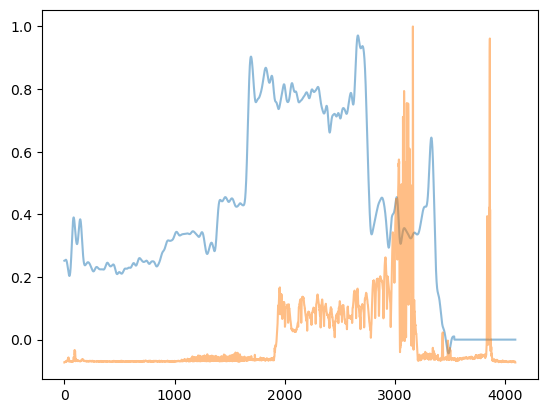

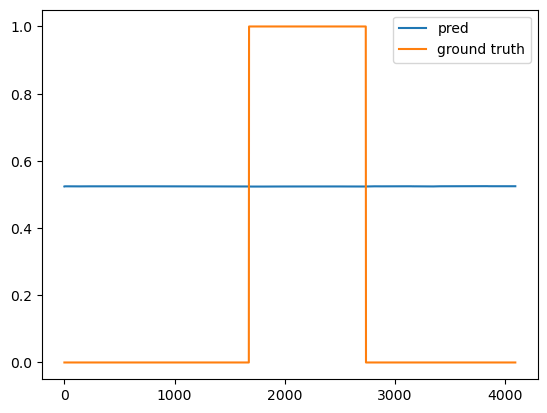

In [14]:
import matplotlib.pyplot as plt

testing_data = test_set[0]
for idx in range(testing_data[0].shape[1]):
    plt.plot(testing_data[0][:, idx], alpha=0.5)
plt.show()

with torch.no_grad():
    pred = torch.sigmoid(model(testing_data[0]))
    # print(f'Before training : label={testing_data[1]}, pred={pred}')
    plt.plot(pred.detach().numpy(), label='pred')
    plt.plot(testing_data[1], label='ground truth')
    plt.legend()


Epoch 289: 100%|██████████| 3/3 [00:00<00:00, 42.25batch/s, loss=0.236]


val_losses.shape=290


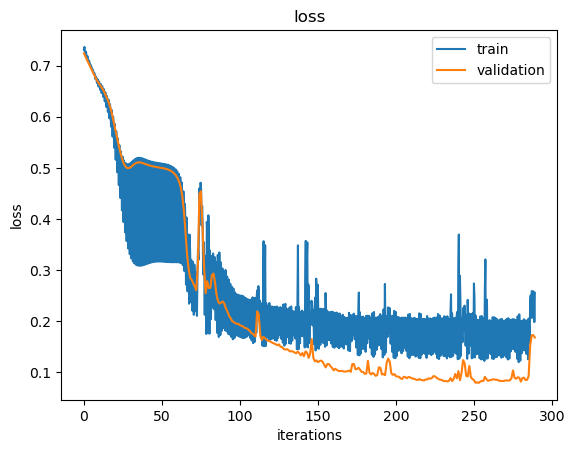

In [15]:
train(model, 
      train_loader, 
      val_loader, 
      optimizer, 
      criterion, 
      device, 
      n_epochs=500, 
      l1_sigma = l1_sigma,
      early_stopping=early_stopping)

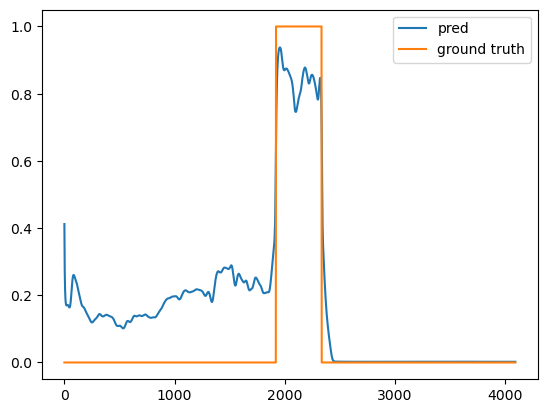

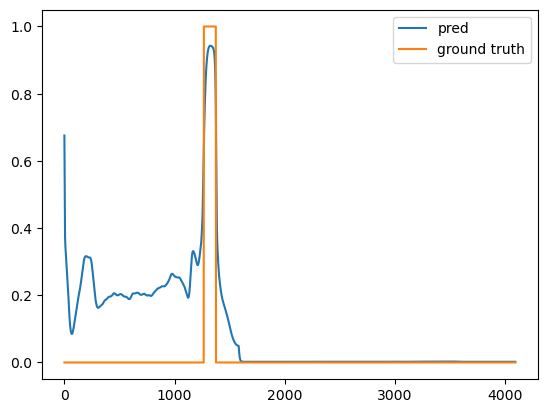

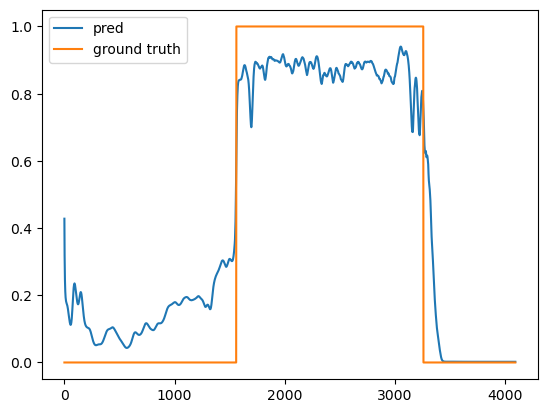

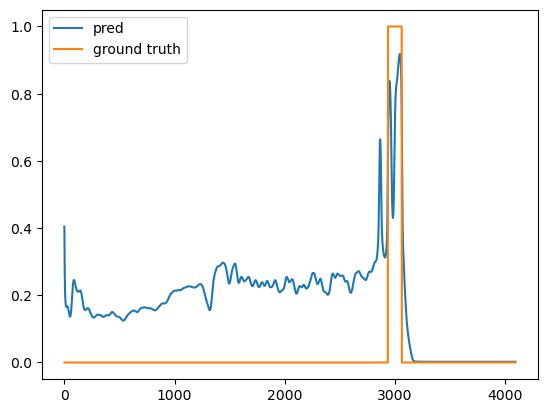

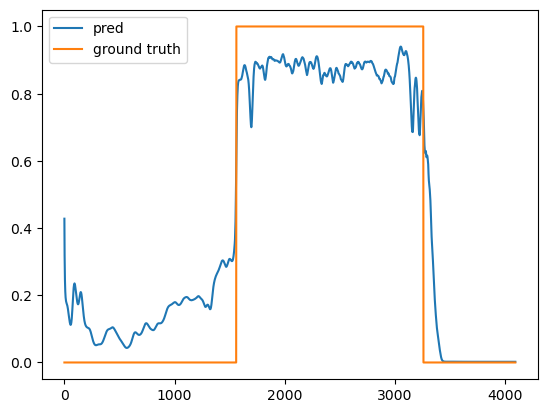

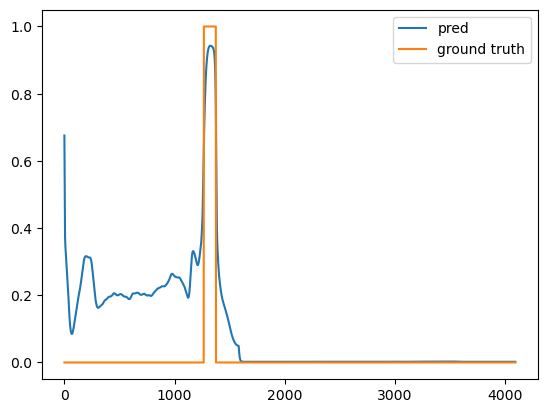

In [16]:
import numpy as np

model.eval()
with torch.no_grad():
    for idx in np.random.choice(len(test_set), 6): 
        testing_data = test_set[idx]
        pred = torch.sigmoid(model(testing_data[0].to(device)))
        plt.plot(pred.detach().cpu().numpy(), label='pred')
        plt.plot(testing_data[1], label='ground truth')
        plt.legend()
        plt.show()